**Dogs VS Cats Classification Problem**

The Dogs & Cats is a foundational problem for a basic CNN(convolutional neural network) model which involves classifying images as a dog or a cat.The dataset can be used for learning how to develop,evaluate and use convolutional deep learning neural networks for classification of images. This includes how to develop a robust test harness for estimating the performance of the model, exploring improvements for the model by changing the paramters of the model, saving and loading the model to make predicitions on new data. In this article, we will discover how to develop a CNN to classify images of dogs and cats.

After reading this article, you will know :
* How to load and prepare the images for training purpose.
* How to split data for training and validation purpose.
* How to apply Data Augmentation to the data.
* How to develop a CNN model using keras and how to choose various parameters for improving performance of the model.
* How to evaluate performance of our model.
* How to save and load a model for further predictions.
* How to draw the confusion matrix for trained model.
* How to predict a new image from trained model.

The dataset can be downloaded for free from the Kaggle website.
Download the dataset by visiting the Dogs vs. Cats Data page and click the “Download All” button.
Dataset Link : https://www.kaggle.com/c/dogs-vs-cats
This will download the 850-megabyte file “dogs-vs-cats.zip” to your workstation.
Unzip the file and you will see train.zip, train1.zip and a .csv file. Unzip the train.zip file, as we will be focusing only on this dataset.
You will now have a folder called ‘train/‘ that contains 25,000 .jpg files of dogs and cats. The photos are labeled by their filename, with the word “dog” or “cat“. 

**Import Library**

In [ ]:
import os
import cv2
import random
import shutil
import numpy as np 
import pandas as pd 
import seaborn as sns
from keras.models import load_model
import matplotlib.pyplot as plt
from matplotlib.image import imread
from sklearn.metrics import confusion_matrix,classification_report
from keras.preprocessing.image import ImageDataGenerator,load_img
from keras.models import Sequential,Model
from keras.layers import Conv2D,Flatten,MaxPooling2D,Dense,GlobalAveragePooling2D,Dropout,BatchNormalization
from sklearn.model_selection import train_test_split
from keras.callbacks import ReduceLROnPlateau

**Prepare Training Data**

Now our dataset contains only images of dogs and cats with filenames like 'dog.1.png' or 'cat.255.png'. Here we have prepared our label dataset by splitting image name with '.'  eg  if image name is 'dog.1.png' we split it by '.' as delimiter and extract first part of image name ('dog' here ) and if it is dog the we append 1 in list else we append 0 in list.So now basically we have our dataset comprising of images and labels corresponding to each images 
* if label = 1 , image corresponds to dog and 
* label = 0 if image corresponds to cat.

We have stored filenames and labels using pandas dataframe.

In [ ]:
import zipfile
with zipfile.ZipFile("../input/dogs-vs-cats/"+'train'+".zip","r") as z:
    z.extractall(".")

In [ ]:
Y = []
path = "./train"
filenames = os.listdir(path)
for img in os.listdir(path):
    val = img.split(".")[0]
    if val == "dog":
        Y.append('1')
    else:
        Y.append('0')

df = pd.DataFrame({
    'filename' : filenames,
    'category' : Y
})

Here we see few initial values of our dataframe using df.head()

In [ ]:
df.head()

Here we see few last values of our dataframe using df.tail()

In [ ]:
df.tail()

**Plot Random Dataset Image**

Looking at a few random images in the directory, we can see that the images are coloured and have different shapes and sizes. For example, let’s load and plot some random images of dataset in a single figure. Running below code creates a figure showing some random images from the dataset.We can see that some images are landscape format, some are portrait format, and some are square.

In [ ]:
plt.figure(figsize=(12, 12))
for i in range(0, 9):
    plt.subplot(4, 3, i+1)
    sample = random.choice(filenames)
    filename = path+'/'+sample
    image = imread(filename)
    plt.imshow(image)
plt.tight_layout()
plt.show()

**Train Test Split**

Here we are splitting our dataset into two parts. We are separating 20% of our dataset images for validation purpose and keeping rest for training purpose.This is done because we want to validate our trained model on a new set of images and not on the same set of images on which the model is trained. Therefore we want a different set of images apart from our training set upon which we can test our model and see the performance of the trained model on new unseen images.

In [ ]:
train_df,val_df = train_test_split(df,test_size=0.2,random_state = 42)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

**Training Dataframe shape**

To see our training dataframe shape we are using train_df.shape

In [ ]:
train_df.shape

**Validation Dataframe shape**

To see our training dataframe shape we are using val_df.shape

In [ ]:
val_df.shape

**Total Count**

Here by running below code we can see from the plot that images of both dogs and cats are almost equal in both our training and validation dataset. If there is too much difference in number of dogs and cats images then it can cause problem in training of our model

In [ ]:
train_df['category'].value_counts().plot.bar()

In [ ]:
val_df['category'].value_counts().plot.bar()

**Selecting Image Size**

The photos will have to be reshaped prior to modeling so that all images have the same shape. So we will choose some image height and width constants which will be used later to reshape all images while training process. Here we choose image height and image width as 128,128. That is 25,000 images with 128x128x3 pixels each, or 1,228,800,000 32-bit pixel values.

**Constants**

Here we are defining constants to be used in our model code. So as to make our code modular we define all constants in a separate cell.


In [ ]:
batch_size = 32
epochs = 30
train_size = train_df.shape[0]
val_size = val_df.shape[0]
img_hieght = 128
img_width = 128
img_channels = 3

**Training Generator**

Image data augmentation is a technique that can be used to artificially expand the size of a training dataset by creating modified versions of images in the dataset.Training deep learning neural network models on more data can result in more skillful models, and the augmentation techniques can create variations of the images that can improve the ability of the fit models to generalize what they have learned to new images. Data augmentation can also act as a regularization technique, adding noise to the training data, and encouraging the model to learn the same features, invariant to their position in the input. Small changes to the input photos of dogs and cats might be useful for this problem, such as small shifts and horizontal flips. These augmentations can be specified as arguments to the ImageDataGenerator used for the training dataset. The augmentations should not be used for the validation dataset, as we wish to evaluate the performance of the model on the unmodified photographs.                    
We can use the flow_from_dataframe() function on the data generator and create one iterator for each of the train and validation set. With the help of flow_from_dataframe method you can directly pass the Pandas DataFrame which has the mapping between filenames of the images and their labels..We must specify that the problem is a binary classification problem via the “class_mode” argument, and to load the images with the size of 128×128×3 pixels via the “target_size” argument. We will fix the batch size at 32.

In [ ]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 15,
    horizontal_flip = True,
    zoom_range = 0.2,
    shear_range = 0.1,
    fill_mode = 'reflect',
    width_shift_range = 0.1,
    height_shift_range = 0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    "./train",
    x_col = 'filename',
    y_col = 'category',
    target_size = (img_hieght,img_width),
    batch_size = batch_size,
    class_mode = 'binary'
)

**Working of Image Generator**

Here we will see working of our training image generator by applying augmentation on a single image selected from our training dataframe.

In [ ]:
example_df = train_df.sample(n=1)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "./train",
    x_col='filename',
    y_col='category',
    target_size=(img_hieght,img_width),
    class_mode='raw'
)

We can see by running below code 9 different variations of a single image created by data augmentation techniques. We can see how these 9 images differ only by some properties like horizontal flip, zoom etc from each other.

In [ ]:
plt.figure(figsize=(12, 12))
for i in range(0, 9):
    plt.subplot(4, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

**Validation Generator**

We will not apply any data augmentation technique like horizontal flip, zoom etc on validation set because we are not going to use this for training purpose.

In [ ]:
val_datagen = ImageDataGenerator(
    rescale = 1./255,
)

val_generator = val_datagen.flow_from_dataframe(
    val_df,
    "./train",
    x_col = 'filename',
    y_col = 'category',
    target_size = (img_hieght,img_width),
    batch_size = batch_size,
    class_mode = 'binary'
)

**Building the Model**

In this section, we can develop a convolutional neural network model for the dogs vs. cats dataset.

*Layers needed by CNN*

* ** Conv2D** :- Basic Convolutional layer which is used to extract features from our image.
* ** MaxPooling ** :- CNN has a concept of max pooling. After every convoulution we get some values in a kernel. However in max pooling we select max kernel value.It helps us to reduce unnecessary noise from our data and keep only useful values for training.
* **  BatchNormalization** :- This layer helps for normalization of our input values which helps in fast learning of our model.
* **  Droupout** :- Dropout works by probabilistically removing, or “dropping out,” inputs to a layer, which may be input variables in the data sample or activations from a previous layer. It has the effect of simulating a large number of networks with very different network structures and, in turn, making nodes in the network generally more robust to the inputs.
* ** Dense** :- Dense layer is needed by every neural network to finally output the result however every once in while using a Dense layer helps in making model learn.
* **  Flatten**:- Conv2D layer returns doesn't return a flatten data hence we need Flatten layer before feeding it into final Dense layer.

In the following architecture filter size goes on increasing in each consecutive cnn layer from 32,64,128 to 256. The reason for this is that as we move forward in the layers the patterns gets more complex, hence we have to capture larger combinations of patterns. That's why we increase filter size in the subsequent layers to capture as many combinations as possible.Also here I tested model with both 3 CNN layers and 4 CNN layers and got good accuracy with 4 CNN layers so due to that I took 4 CNN layers in the final model.

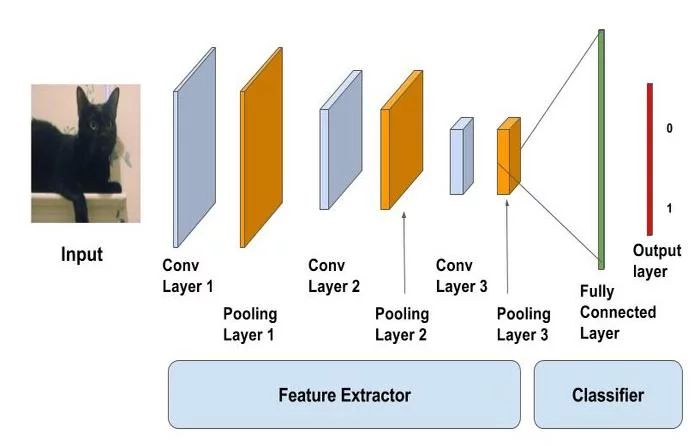
This image is just an example of cnn model, it not describes our exact model

In [ ]:
model = Sequential()

model.add(Conv2D(32,(3,3),activation='relu',input_shape = (img_hieght,img_width,img_channels)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(256,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(1,activation='sigmoid'))

**Callbacks**

Models often benefit from reducing the learning rate by a factor once learning stagnates. This callback monitors a quantity and if no improvement is seen for a 'patience' number of epochs, the learning rate is reduced.Basically if learning rate is too low the model requires many updates before reaching minimum point so we need to increase leraning rate but if it gets increaed too much then it causes drastic updates which leads to degradation of performance so at that time we need to reduce the learning rate. We are taking care of this thing in our model with this callback (ReduceLROnPlateau).

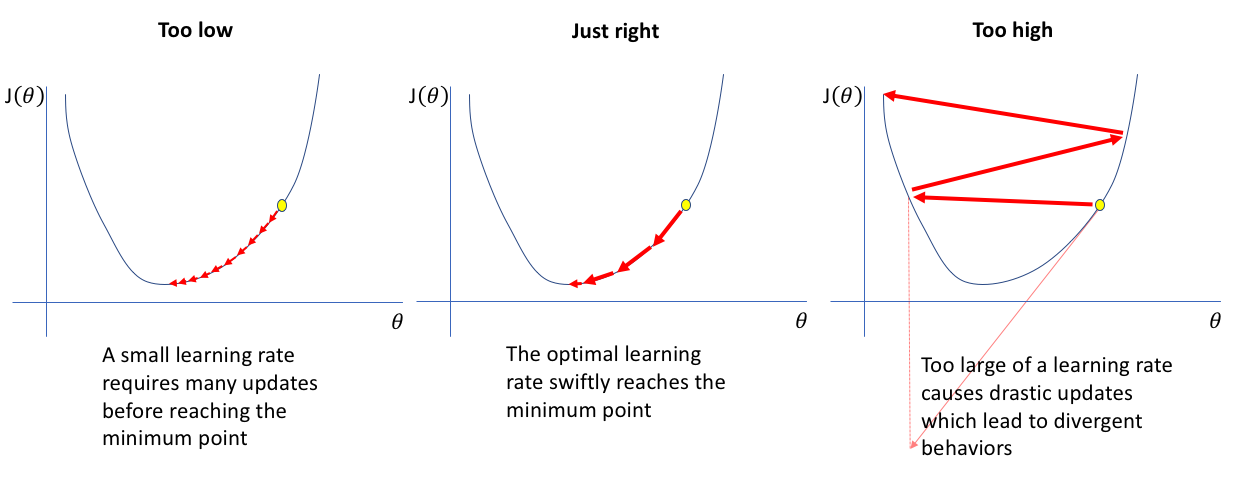

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_accuracy',
                                            patience=2,
                                            factor=0.5,
                                            min_lr = 0.00001,
                                            verbose = 1)
callbacks = [learning_rate_reduction]

model.summary() gives the description of the architecture of our model.

In [ ]:
model.summary()

Finally we will compile the model .There are 3 things to mention here : Optimizer,Loss, Metrics
* Optimizer :- To minimize cost function we use different methods For ex :- like gradient descent, stochastic gradient descent. So these are call optimizers. We are using a default one here which is adam.
* Loss :- To make our model better we either minimize loss or maximize accuracy. Neural Networks always minimize loss. To measure it we can use different formulas like 'categorical_crossentropy' or 'binary_crossentropy'. Here I have used binary_crossentropy.
* Metrics :- This is to denote the measure of your model. Can be accuracy or some other metric.

In [ ]:
model.compile(optimizer='Adam',loss='binary_crossentropy',metrics=['accuracy'])

**Fit Model**

We are now going to train our compiled model using the train iterator (train_generator) and use the val iterator (val_generator) as a validation dataset during training.The number of steps for the train and validation iterators must be specified. This is the number of batches that will comprise one epoch. This can be specified via the length of each iterator, and will be the total number of images in the train and validation directories divided by the batch size (32).The model will be fit for 30 epochs.

In [ ]:
model.fit_generator(
    train_generator,
    epochs = epochs,
    validation_data =  val_generator,
    steps_per_epoch = train_size//batch_size,
    validation_steps = val_size//batch_size,
    callbacks = callbacks
)

**Saving the Model**

Once fit, we can save the final model to an .h5 file by calling the save() function on the model and pass in the chosen filename.

In [ ]:
model.save("model.h5")

Below code can be used to load model weights from save model.h5 file. So that we don't have to go through full trainnig process again.

In [ ]:
# model = load_model("/kaggle/input/mode-file/model.h5")

**Validation Accuracy**

Now we will calculate our model's accuracy on validation set with use of keras  *.evaluate_generator()* function. We have used score[1]*100 because output of evaluate_generator() is a list of which second element represents accuracy of model on passed dataset.

In [ ]:
score = model.evaluate_generator(val_generator)
print(score[1]*100)

**Training Accuracy**

Here we are going to calculate model's accuracy on training set itself.

In [ ]:
score = model.evaluate_generator(train_generator)
print(score[1]*100)

**Confusion Matrix**

A confusion matrix is a table that is often used to describe the performance of a classification model (or "classifier") on a set of test data for which the true values are known.So here we are going to draw confusion matrix for our model with use of sklearn.metrics.confusion_matrix inbuilt function. What can we learn from this matrix ?
* There are two possible predicted classes: 0 and 1. If we were predicting the dog, for example, 1 would mean image represents dog, and 0 would mean that image represents cat.
* true positives (TP): These are cases in which we predicted 1 (the image is of dog), and the image is of dog.
* true negatives (TN): We predicted 0, and the image is of cat.
* false positives (FP): We predicted 1, but the image is of cat. (Also known as a "Type I error.")
* false negatives (FN): We predicted 0, but the image is of dog. (Also known as a "Type II error.")

We want to draw confusion matrix on validation dataset for our trained model so for that purpose we need to use argument shuffle = "False" in our generator because we want predicted and true labels for validation dataset. So for that we made two iterators to validation dataset in which one is used as validation dataset (val_generator) and one (conf_generator) for drawing confusion matrix.

In [ ]:
conf_datagen = ImageDataGenerator(
    rescale = 1./255,
)

conf_generator = conf_datagen.flow_from_dataframe(
    val_df,
    "./train",
    x_col = 'filename',
    y_col = 'category',
    target_size = (img_hieght,img_width),
    batch_size = batch_size,
    shuffle = False,
    class_mode = 'binary'
)

In [ ]:
y_predict = model.predict_generator(conf_generator)

In [ ]:
y_predict = np.where(y_predict > 0.5, 1, 0)

In [ ]:
p = conf_generator.classes
q = y_predict
p = np.array(p)
q = q.flatten()

In [ ]:
cfm = confusion_matrix(p, q)
print(cfm)
ax= plt.subplot()
sns.heatmap(cfm, annot=True, ax = ax);
# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['cats', 'dogs'])
ax.yaxis.set_ticklabels(['cats', 'dogs'])

The classification report visualizer displays the precision, recall, F1, and support scores for the model.Here we are using sklearn.metrics.classification_reports function to see the measures.

In [ ]:
print(classification_report(p,q))

**Prediction**

Here we will see the prediction of our model on a new image with use of model.predict function

In [ ]:
path = "/kaggle/input/test-images/dog.jpeg"
img = cv2.imread(path)
plt.imshow(img)
img = cv2.resize(img,(128,128))
img = np.reshape(img,[1,128,128,3])
img = np.divide(img,255)
result = model.predict(img)
if result[0] >= 0.5:
    print("According to our model's prediction below image is of a Dog")
else:
    print("According to our model's prediction below image is of a Cat")

In [ ]:
shutil.rmtree("./train")

**Resnet**

Transfer learning involves using all or parts of a model trained on a related task.Keras provides a range of pre-trained models that can be loaded and used wholly or partially via the Keras Applications API.
A useful model for transfer learning is one of the ResNet models, such as ResNet-50 with 50 layers that at the time it was developed, achieved top results. We can use the feature extraction part of the model and add a new classifier part of the model that is tailored to the dogs and cats dataset. Specifically, we can hold the weights of all of the convolutional layers fixed during training, and only train new fully connected layers that will learn to interpret the features extracted from the model and make a binary classification.
This can be achieved by loading the ResNet-50 model, removing the fully connected layers from the output-end of the model, then adding the new fully connected layers to interpret the model output and make a prediction. The classifier part of the model can be removed automatically by setting the “include_top” argument to “False“, which also requires that the shape of the input also be specified for the model, in this case (128, 128, 3).

In [ ]:
# from keras.applications.resnet50 import ResNet50

In [ ]:
# base_model = ResNet50(include_top=False,weights=None,input_shape=(128,128,3))
# res_model = base_model.output
# res_model = GlobalAveragePooling2D()(res_model)
# res_model = Dropout(0.5)(res_model)
# predictions = Dense(1,activation='sigmoid')(res_model)
# model = Model(inputs = base_model.input,outputs = predictions)

Author : Kanish Anand , AI data engineer